In [26]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm

In [27]:
#gsparams=galsim.GSParams()
gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)
#gsparams = galsim.GSParams(maximum_fft_size=2048*8)

In [28]:
def makeGaussian(im, flux=1., gsparams=None):
    im_mom = galsim.hsm.FindAdaptiveMom(im,strict=False)
    if im_mom.moments_status != 0:
        #print im_mom.correction_status
        return False, False, False
    else:
        im_mom_sigma, im_mom_shear = im_mom.moments_sigma*im.scale, im_mom.observed_shape
        im_gaussian = galsim.Gaussian(sigma=im_mom_sigma, flux=flux, gsparams=gsparams)
        #im_gaussian = im_gaussian.shear(g1=im_mom_shear.g1,g2=im_mom_shear.g2)
        return im_gaussian, im_mom_sigma, im_mom_shear


In [57]:
pixel_scale = 0.1 #as/px
lamda = 550 #nm
diameter = 1.2 #m
psf_oversample = 5.
gal_oversample = 2.

airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)

#image_psf = psf.drawImage(scale=pixel_scale/20.,method='no_pixel') #Fit a Gaussian
#psf_gaussian = makeGaussian(image_psf,gsparams=gsparams)[0]

psf_gaussian = psf #Now a misnomer, make it Airy
given_psf = psf_gaussian.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image

#gauss_psfii = psf_gaussian
gauss_psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)


(550, 550)


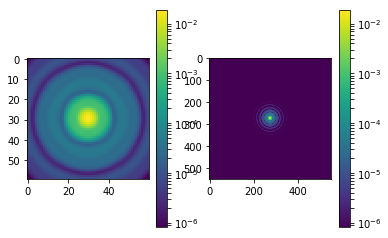

In [58]:
fig,ax=plt.subplots(1,2)
stamp=galsim.ImageF(60,60)
new_image_psf = psf.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel',image=stamp)
vmin,vmax=np.min(new_image_psf.array),np.max(new_image_psf.array)
f1=ax[0].imshow(new_image_psf.array,norm=LogNorm(),vmin=vmin,vmax=vmax)
f2=ax[1].imshow(given_psf.array,norm=LogNorm(),vmin=vmin,vmax=vmax)
fig.colorbar(f1,ax=ax[0])
fig.colorbar(f2,ax=ax[1])
print given_psf.array.shape

In [59]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
hlr, sn, q = [np.array([pc[4][i] for pc in cc.param_cat]) for i in range(1,4)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][0] #Large galaxies, reasonable sersic n
gal = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)


In [60]:
print gal
#plt.imshow(gal.drawImage(scale=pixel_scale).array,norm=LogNorm())
#plt.colorbar()
# print np.min(gal.drawImage(scale=pixel_scale).array)
# print np.max(gal.drawImage(scale=pixel_scale).array)

galsim.Sersic(n=1.0, half_light_radius=0.108705859505, flux=2.16024879771).shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))


In [61]:
# print gal
# gal = galsim.Sersic(n=1.0,half_light_radius=0.108705859505, flux=2.16024879771,gsparams=gsparams)
# gal = gal.shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))
# #gal=gal.transform(0.8222,0.260355,0.260355,1.29868)
# print gal
# galExp = galsim.Exponential(half_light_radius=0.108705859505, flux=2.16024879771,gsparams=gsparams)
# galExp = galExp.shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))
# print galExp
# gal = galExp

# gal = gal.dilate(1)

In [62]:
fin = galsim.Convolve([gal,psf_gaussian])
given_im = fin.drawImage(scale=pixel_scale/gal_oversample, method='no_pixel')

In [63]:
#gal_interp = fin
gal_interp = galsim.InterpolatedImage(given_im,gsparams=gsparams)

In [64]:
inv_gauss = galsim.Deconvolve(gauss_psfii)
dec = galsim.Convolve(gal_interp,inv_gauss)
rec = galsim.Convolve(dec, gauss_psfii)

recIm = rec.drawImage(scale=pixel_scale/gal_oversample,method='no_pixel')

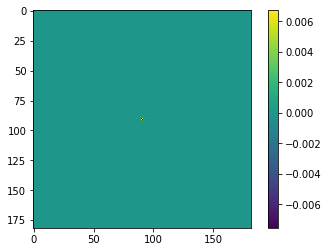

In [65]:
decIm = dec.drawImage(scale=pixel_scale/gal_oversample)
ss=decIm.array.shape[0]
stamp=galsim.ImageF(ss,ss)
plt.imshow(decIm.array - gal.drawImage(image=stamp,scale=pixel_scale/gal_oversample).array)
plt.colorbar()

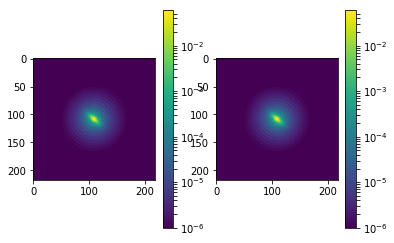

In [66]:
fig,ax=plt.subplots(1,2)
recsize = recIm.array.shape[0]
origIm = galsim.ImageF(recsize,recsize)
origIm = fin.drawImage(image=origIm,scale=pixel_scale/gal_oversample,method='no_pixel')
f1=ax[0].imshow(origIm.array,norm=LogNorm(),vmin=1e-6)
f2=ax[1].imshow(recIm.array,norm=LogNorm(),vmin=1e-6)

fig.colorbar(f1,ax=ax[0])
fig.colorbar(f2,ax=ax[1])

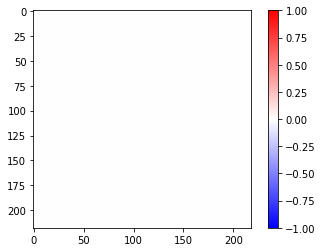

In [67]:
plt.imshow(origIm.array / recIm.array - 1,vmin=-1e-0,vmax=1e-0,cmap=cm.bwr)
plt.colorbar()

In [1]:
plt.imshow((origIm.array - recIm.array)*1e6,vmin=-2,vmax=2,cmap=cm.bwr)
plt.colorbar()

NameError: name 'plt' is not defined

In [41]:
print np.max(np.abs(origIm.array - recIm.array))

0.00018530339


In [42]:
orig_shape=galsim.hsm.FindAdaptiveMom(origIm).observed_shape
print orig_shape.e1, orig_shape.e2

rec_shape=galsim.hsm.FindAdaptiveMom(recIm).observed_shape
print rec_shape.e1, rec_shape.e2

0.0668098852038 0.572341680527
0.0667040273547 0.572005212307


In [43]:
print 1-rec_shape.e1/orig_shape.e1, 1-rec_shape.e2/orig_shape.e2

0.00158446386786 0.000587879987086


In [44]:
print np.abs(rec_shape.e1-orig_shape.e1), np.abs(rec_shape.e2-orig_shape.e2)

0.00010585784912109375 0.0003364682197570801
